In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from loadBeh import loadBeh
import events as eve

In [8]:
def loopMice(mice):
    """
    """
    fileList = pd.DataFrame({'Mouse':[], 'Session':[], 'Data':[], 'Behaviour':[]})
    for mus,sess in mice:
        dataPath = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\" + str(mus) + "_FR1_Test\\Filtered_32-bit_2X2\\ICs_" + str(sess) + "\\M" + str(mus) + "_recording_ICs.csv"
        behPath = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\" + str(mus) + "_FR1_Behaviour\\" + str(mus) + "_FR1_Behaviour.csv"
        musList = pd.DataFrame({ 'Mouse' : mus, 'Session' : sess, 'Data' : dataPath, 'Behaviour' : behPath }, index=[mus], dtype=object)
        fileList = fileList.append(musList)
    
    return fileList

In [9]:
def loadData(mice):
    """
        Gets the names of files of all the mice and returns it as a list.
        Input: (<mouse tag>, <session #>)
    """
    # Get the file names
    fileList = loopMice(mice)

    # Load the data
    dataList = {}
    for mus, sess in mice:
        data = pd.read_csv(fileList['Data'].loc[mus], delimiter= ",", skip_blank_lines= True, error_bad_lines= False)

        # Organize the data a little bit
        # Get the frame rate of the recording
        ##fs = data['Time (s)'].iloc[1] - data['Time (s)'].iloc[0]
        # Rearrange the time axis and set the index
        data['Time (s)'] = np.arange(0.00, len(data.index)*fs, fs)
        data = data.set_index(data['Time (s)'])

        dataList[mus] = data.drop('Time (s)', 1)

    return dataList

In [10]:
def getBeh(mice, behList):
    """
    """
    eventList = {}
    hitsList = {}
    missesList = {}
    for mus, sess in mice:
        eventList[mus], hitsList[mus], missesList[mus] = loadBeh(behList[mus])
    
    return eventList, hitsList, missesList

In [11]:
def getBoutDur(mice, eventTypes, events):
    # Load the data
    dataList = loadData(mice)
    
    # Load the events
    fileList = loopMice(mice)
    eventList, hitsList, missesList = getBeh(mice, fileList['Behaviour'])

    durationData = pd.DataFrame()
    for mus, sess in mice:
        # Find the events
        boutDur = np.array([])
        startList = eventList[mus][eventTypes[0]].dropna().values
        endList = eventList[mus][eventTypes[1]].dropna().values
        for i in range(events[0]-1, events[1]):
            ind, start = eve.find_nearest(dataList[mus].index.values, startList[i])
            ind, end = eve.find_nearest(dataList[mus].index.values, endList[i])
            boutDur = np.append(boutDur, end-start)

        durationData[mus] = boutDur
    
    durationData.set_index(np.arange(events[0], events[1]+1), inplace=True)
    
    return durationData

In [12]:
def dFFcalc(mice, dataList, average=0):
    """
        Calculate the dFF for the given dataframe.
        Input: (<mouse tag>, <session #>), dataList
    """
    dFFList = {}
    for mus, sess in mice:
        data = dataList[mus]
        minPoint = data.idxmin(axis= 0)
        
        dFF = pd.DataFrame()
        for i, m in enumerate(minPoint):
            F0 = data[data.columns[i]][m-2.50 : m+2.50].mean(axis= 0)
            dFF[data.columns[i]] = (data[data.columns[i]] - F0) / F0 * 100
        
        # Filter first
        dFF = dFF.rolling(window= average).mean()
        
        # Put each dataframe into the dict
        dFFList[mus] = dFF
    
    return dFFList

In [13]:
def markTrials(mice, base, duration, eventType, trials, dff= True, baseline=False):
    """
    """
    # Load the data
    dataList = loadData(mice)
    if dff:
        dataList = dFFcalc(mice, dataList, average= 5)
    
    # Load the events
    fileList = loopMice(mice)
    eventList, hitsList, missesList = getBeh(mice, fileList['Behaviour'])
    
    eventsData = pd.DataFrame()
    for mus, sess in mice:
        
        # Find the events
        eventTimes = np.array([])
        for i, event in enumerate(eventList[mus][eventType].dropna()):
            ind, nearest = eve.find_nearest(dataList[mus].index.values, event)
            eventTimes = np.append(eventTimes, nearest)
        
        fs = dataList[mus].index[1] - dataList[mus].index[0]
        for col in dataList[mus].columns:
            if not col == 'Time (s)':
                data = dataList[mus][col]
                for i, event in enumerate(eventTimes[trials[0]-1:trials[1]]):
                    slicedData = pd.DataFrame()
                    
                    if baseline:
                        basedFF = data.loc[event-baseline+0.0001:event+0.0001].mean()
                    elif not baseline:
                        basedFF = 0
                        
                    slicedData['Fluoro'] = data.loc[event-base+0.0001:event+duration+0.0001].values - basedFF
                    slicedData['Cell'] = col
                    slicedData['Event'] = i+1
                    slicedData['New_Time'] = np.arange(-base,duration,fs)

                    eventsData = eventsData.append(slicedData)
                    
    print "\n", len(mice), " mice were loaded."
    for mus, sess in mice:
        print "Mouse number", mus, " had ", hitsList[mus], " total rewards."
        
    if baseline:
        print "\nBaseline was set", baseline, "sec before the event."
    elif not baseline:
        print "\nTraces were not baselined."

    return eventsData

In [14]:
def markBouts_(mice, eventTypes, trials, dff=True):
    """
    """
    # Load the data
    dataList = loadData(mice)
    if dff:
        dataList = dFFcalc(mice, dataList, average= 5)
        
    # Get the events
    fileList = loopMice(mice)
    eventList, hitsList, missesList = getBeh(mice, fileList['Behaviour'])
    
    eventsData = pd.DataFrame()
    for mus, sess in mice:
        
        # Find the events
        eventTimes1 = np.array([])
        eventTimes2 = np.array([])
        for i, event in enumerate(eventList[mus][eventTypes[0]].dropna()):
            ind1, nearest1 = eve.find_nearest(dataList[mus].index.values, eventList[mus][eventTypes[0]].loc[i])
            ind2, nearest2 = eve.find_nearest(dataList[mus].index.values, eventList[mus][eventTypes[1]].loc[i])
            eventTimes1 = np.append(eventTimes1, nearest1)
            eventTimes2 = np.append(eventTimes2, nearest2)

        fs = dataList[mus].index[1] - dataList[mus].index[0]
        for col in dataList[mus].columns:
            if not col == 'Time (s)':
                data = dataList[mus][col]
                for i, event in enumerate(eventTimes1[trials[0]-1:trials[1]]):
                    slicedData = pd.DataFrame()
                    start = eventTimes1[i]
                    end = eventTimes2[i]
                    slicedData['Fluoro'] = data.loc[start:end+0.0001].values
                    slicedData['Cell'] = col
                    slicedData['Event'] = i+1
                    slicedData['New_Time'] = np.arange(0.00,end-start+0.0001,fs)

                    eventsData = eventsData.append(slicedData)
                    
    print "\n", len(mice), " mice were loaded."
    for mus, sess in mice:
        print "Mouse number", mus, " had ", hitsList[mus], " total rewards."

    return eventsData

In [15]:
def markBouts(mice, eventTypes, trials, dff=True, resample=False):
    """
    """
    # Load the data
    dataList = loadData(mice)
    if dff:
        dataList = dFFcalc(mice, dataList, average= 5)
        
    # Get the events
    fileList = loopMice(mice)
    eventList, hitsList, missesList = getBeh(mice, fileList['Behaviour'])
    
    eventsData = pd.DataFrame()
    for mus, sess in mice:
        
        # Find the events
        eventTimes1 = np.array([])
        eventTimes2 = np.array([])
        for i, event in enumerate(eventList[mus][eventTypes[0]].dropna()):
            ind1, nearest1 = eve.find_nearest(dataList[mus].index.values, eventList[mus][eventTypes[0]].loc[i])
            ind2, nearest2 = eve.find_nearest(dataList[mus].index.values, eventList[mus][eventTypes[1]].loc[i])
            eventTimes1 = np.append(eventTimes1, nearest1)
            eventTimes2 = np.append(eventTimes2, nearest2)

        eventTimes1 = eventTimes1 - 5.0
        eventTimes2 = eventTimes2 + 5.0
        scaling = 5.0/(eventTimes2 - eventTimes1)
        print scaling
        
        fs = dataList[mus].index[1] - dataList[mus].index[0]
        for col in dataList[mus].columns:
            if not col == 'Time (s)':
                data = dataList[mus][col]
                for i, event in enumerate(eventTimes1[trials[0]-1:trials[1]]):
                    slicedData = pd.DataFrame()
                    start = eventTimes1[i]
                    end = eventTimes2[i]
                    
                    if resample:
                        slicedData['Fluoro'] = sig.resample(data.loc[start:end+0.0001].values, resample)
                        slicedData['New_Time'] = np.linspace(0.00-scaling[i],1.00+scaling[i],resample)
                    else:
                        slicedData['Fluoro'] = data.loc[start:end+0.0001].values
                        slicedData['New_Time'] = np.arange(start,end+0.0001,fs)
                    
                    slicedData['Cell'] = col
                    slicedData['Event'] = i+1
                    
                    eventsData = eventsData.append(slicedData)

    return eventsData

In [17]:
# Start running the analysis
mice = [(8404, 6), (8857, 2), (8864, 1)]
fileList = loopMice(mice)

In [137]:
fs = 0.05
base = 5.0
duration = 25.0
eventType = 'Eat_Start'
trials=[1,12]

In [138]:
eventsData = markTrials(mice, base, duration, eventType, trials=trials, baseline=base)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(-base,duration,fs)

Number of successful rewards received (hits):  15
Number of missed rewards (misses):  2
Number of successful rewards received (hits):  17
Number of missed rewards (misses):  1
Number of successful rewards received (hits):  13
Number of missed rewards (misses):  2

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

Baseline was set 5.0 sec before the event.


In [139]:
cellList = eventsData['Cell'].drop_duplicates().reset_index(drop=True)

cellMeans = pd.DataFrame()
for cell in cellList:
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Cell', 'Event'], columns='New_Time').loc[cell].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Cell', 'Event'], columns='New_Time').loc[cell].sem().values
    dfMeans['Cell'] = cell
    cellMeans = cellMeans.append(dfMeans)
cellMeans

,Mean,Sem,Cell
0,0.168865,0.117084,M8404_recording_ICs1 (Fluorescence (au))
1,0.163768,0.114044,M8404_recording_ICs1 (Fluorescence (au))
2,0.155713,0.109651,M8404_recording_ICs1 (Fluorescence (au))
3,0.155592,0.109023,M8404_recording_ICs1 (Fluorescence (au))
4,0.163094,0.112595,M8404_recording_ICs1 (Fluorescence (au))
5,0.163599,0.114509,M8404_recording_ICs1 (Fluorescence (au))
6,0.149148,0.120371,M8404_recording_ICs1 (Fluorescence (au))
7,0.125680,0.121961,M8404_recording_ICs1 (Fluorescence (au))
8,0.090021,0.118495,M8404_recording_ICs1 (Fluorescence (au))
9,0.063691,0.117773,M8404_recording_ICs1 (Fluorescence (au))


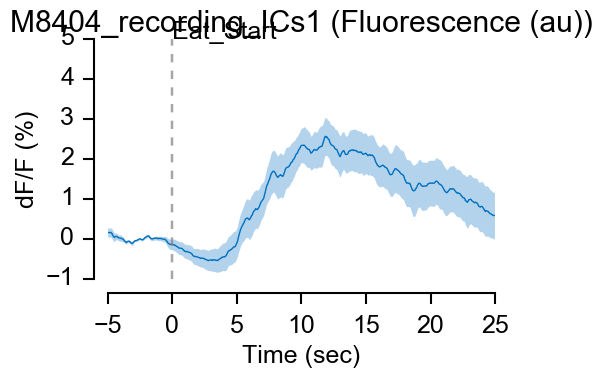

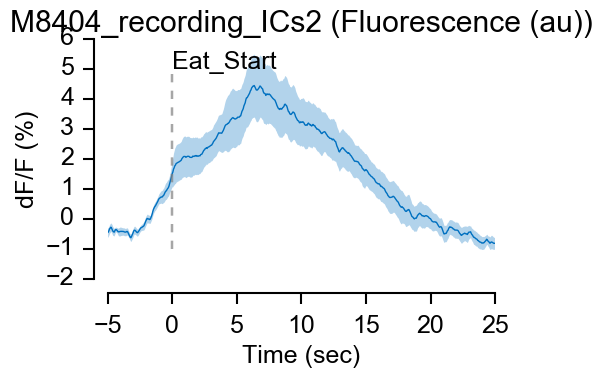

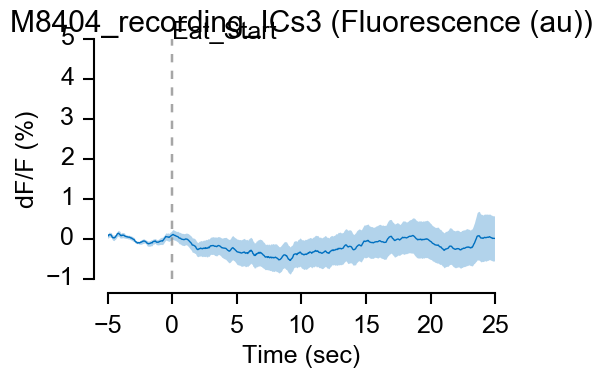

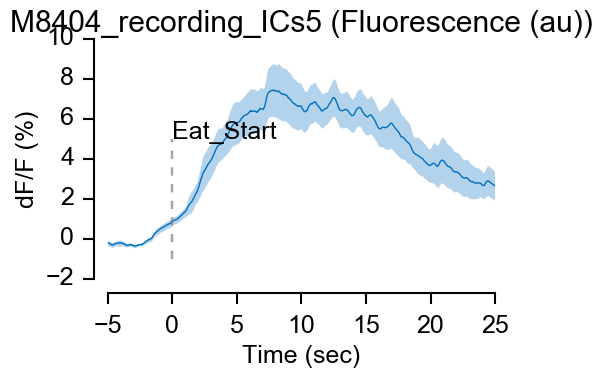

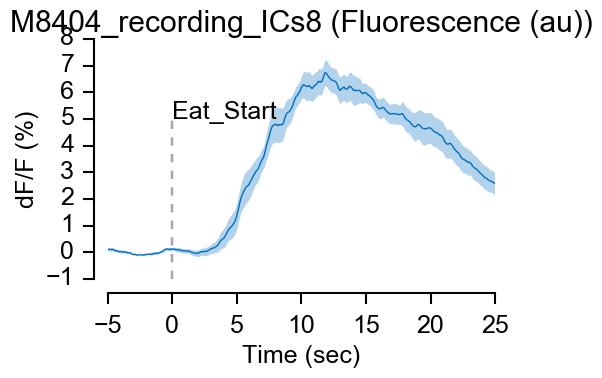

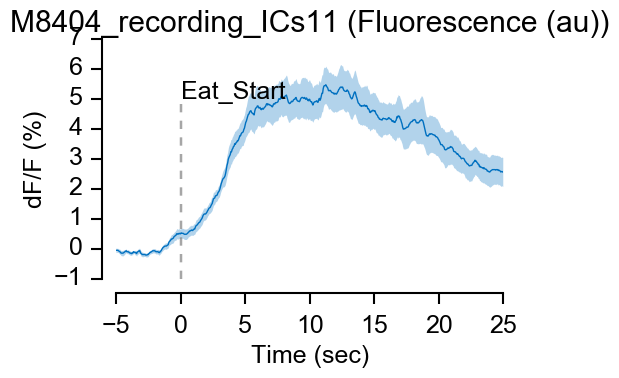

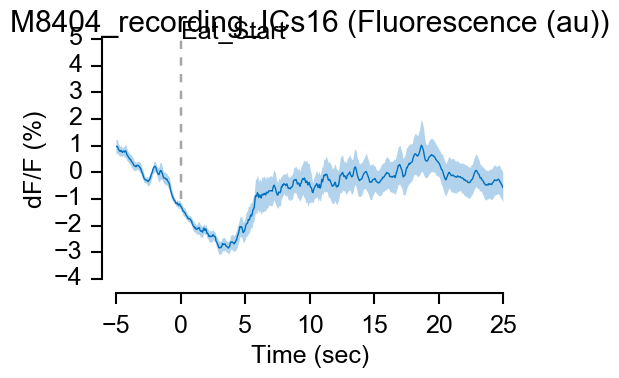

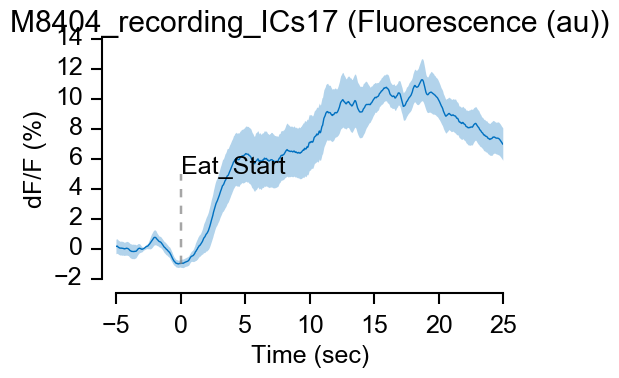

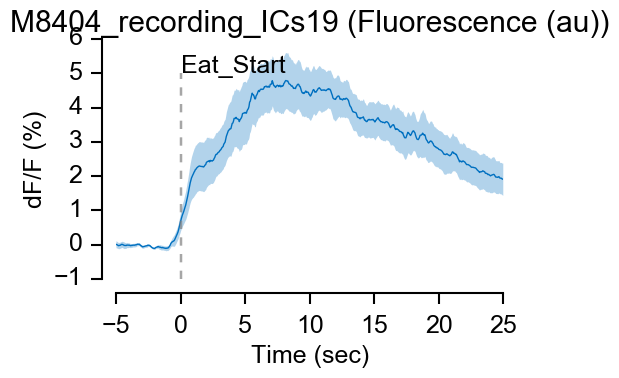

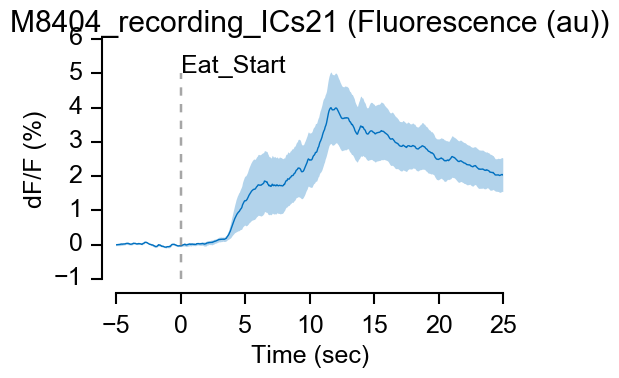

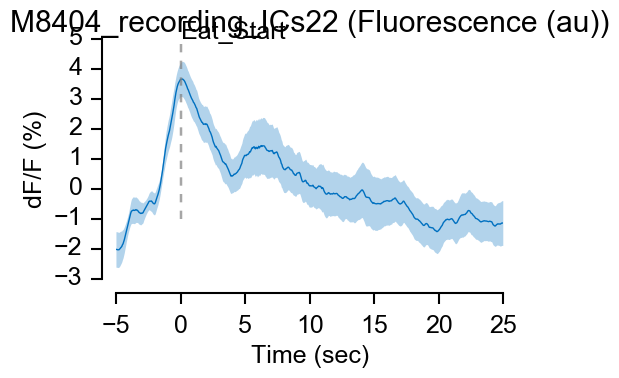

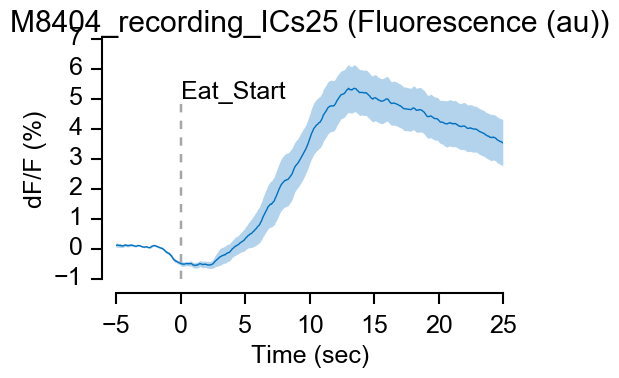

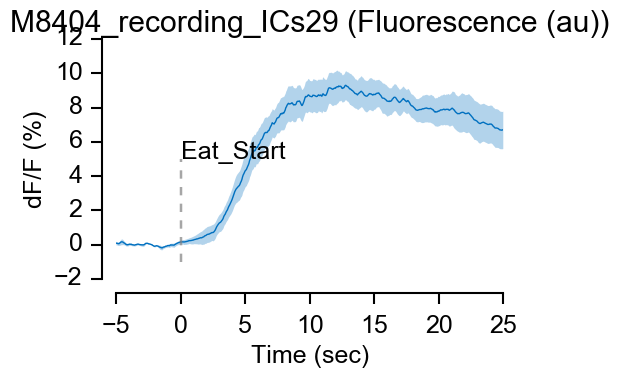

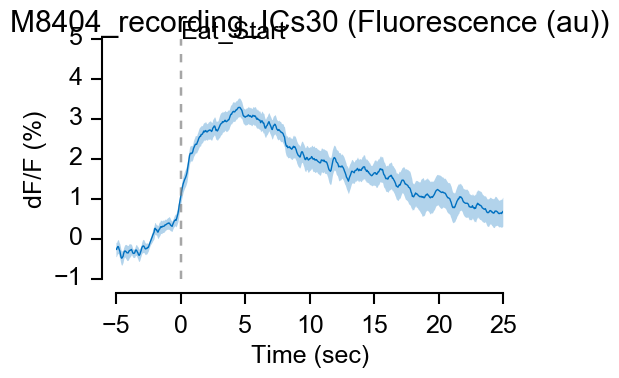

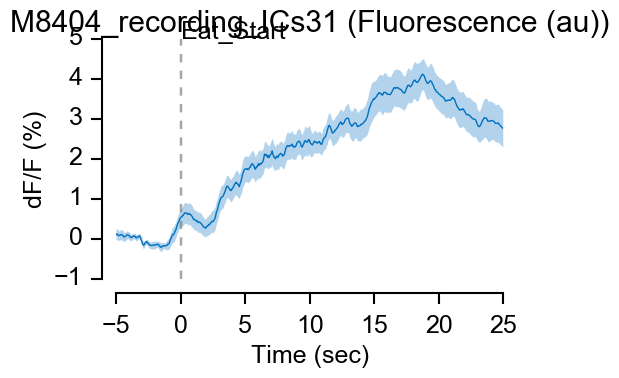

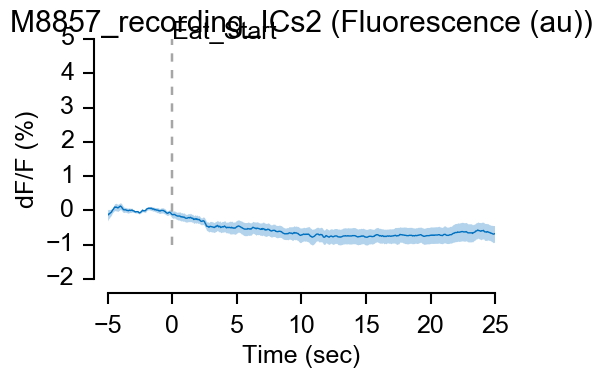

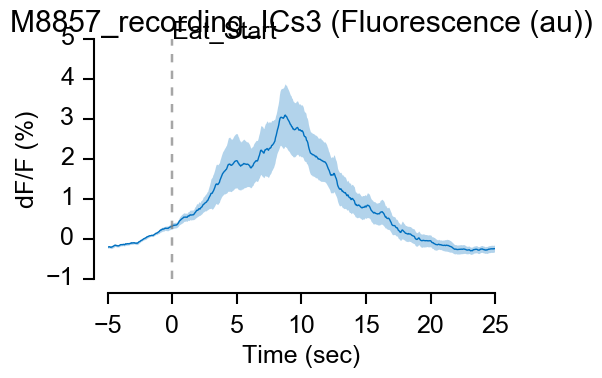

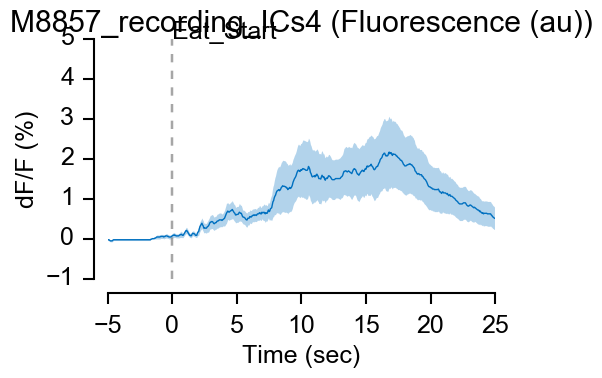

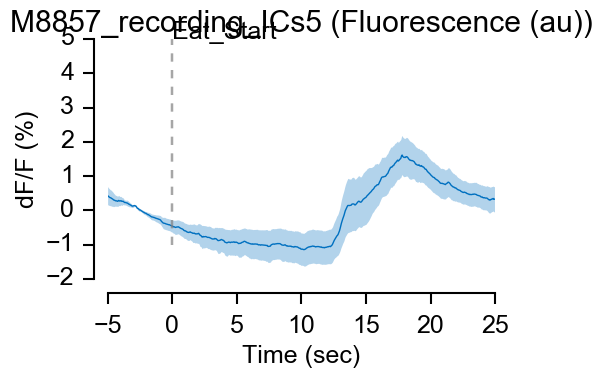

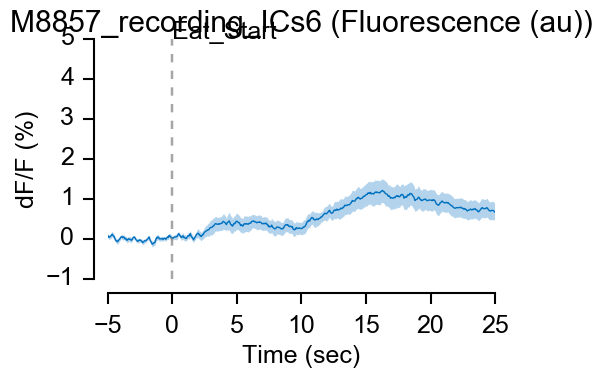

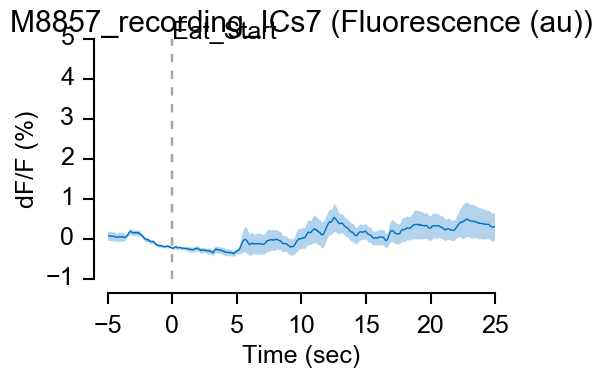

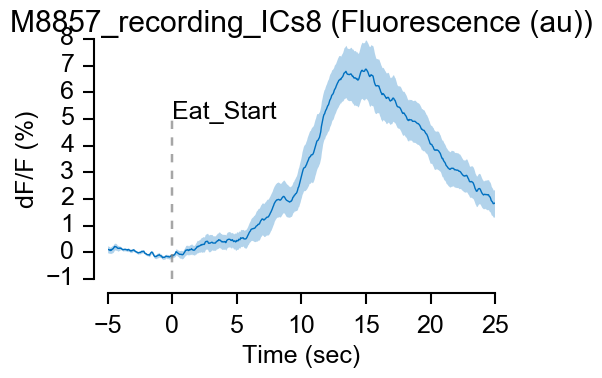

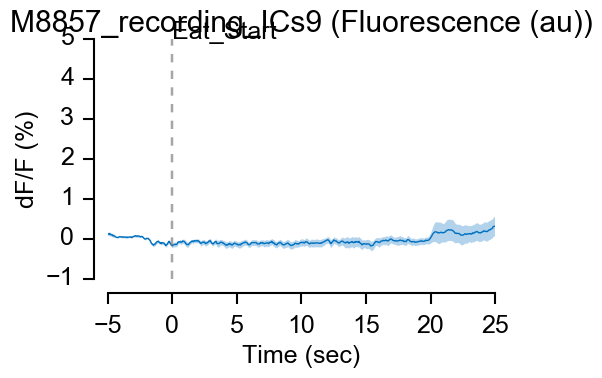

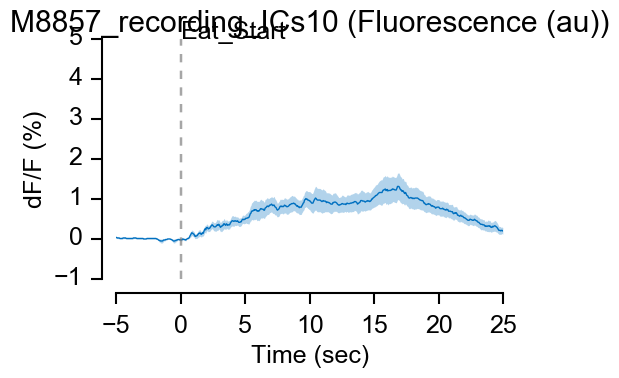

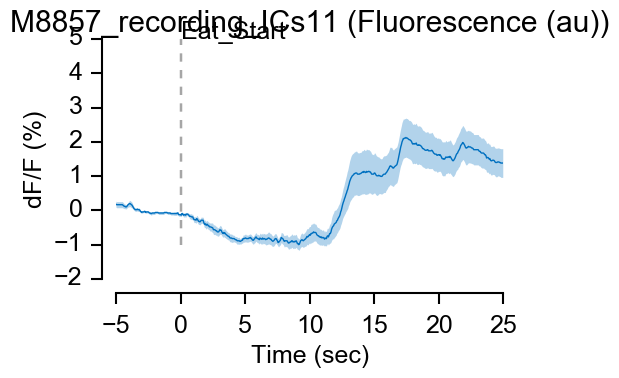

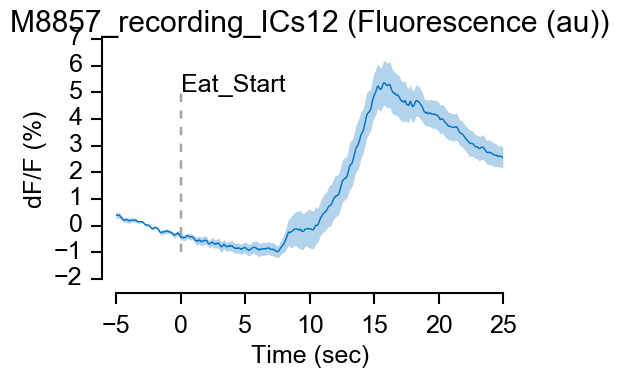

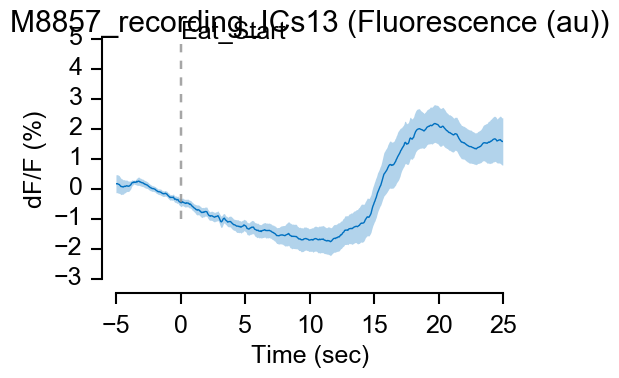

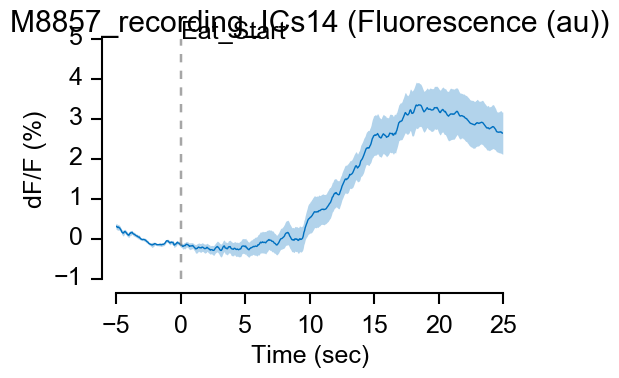

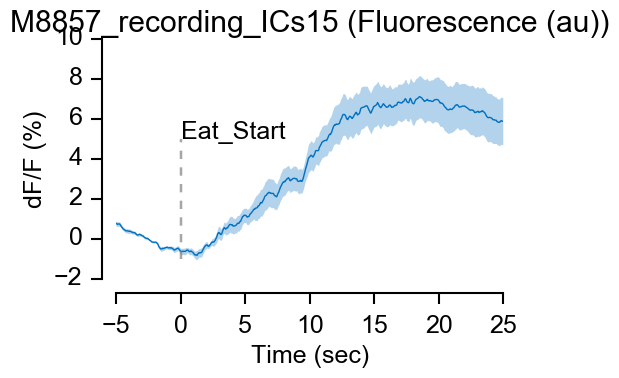

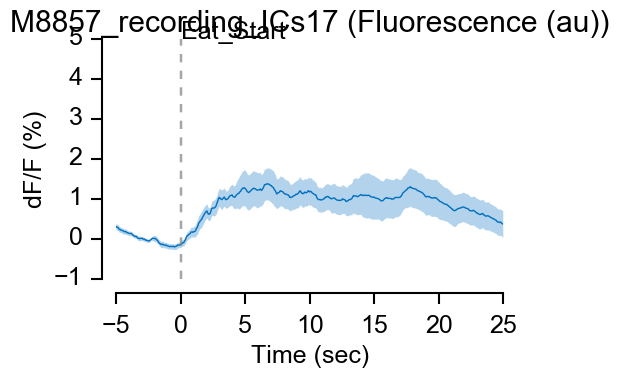

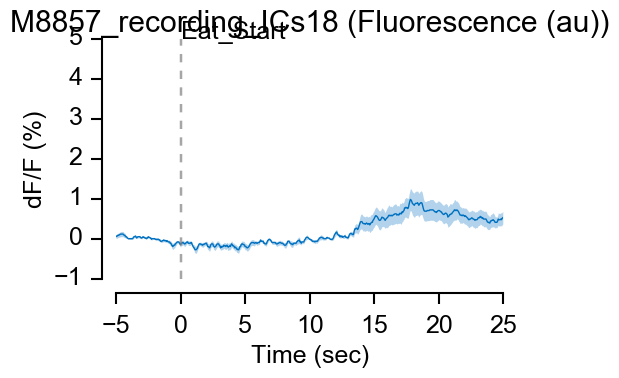

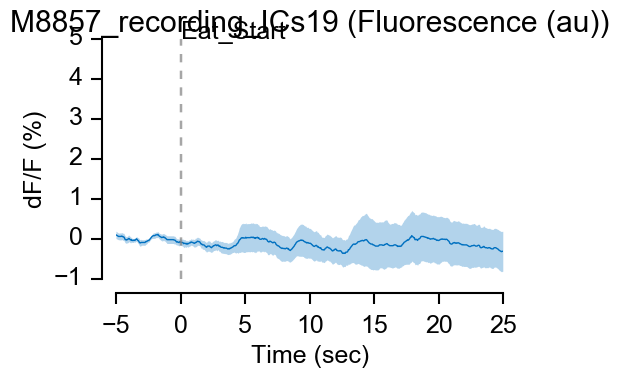

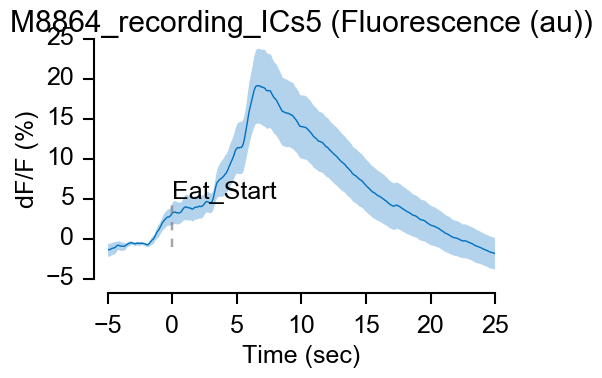

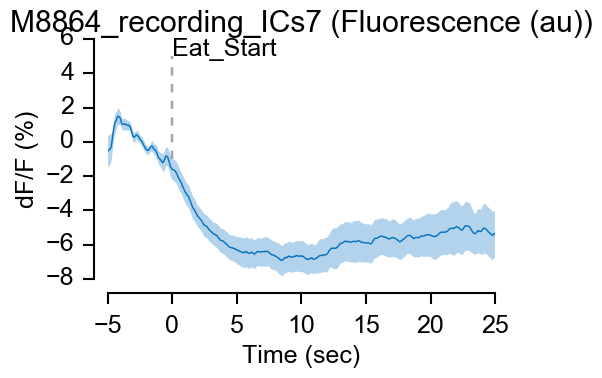

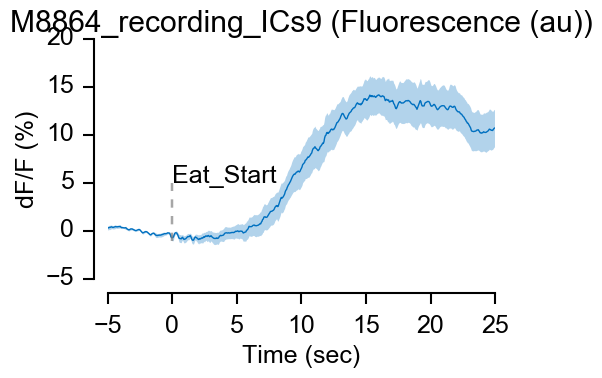

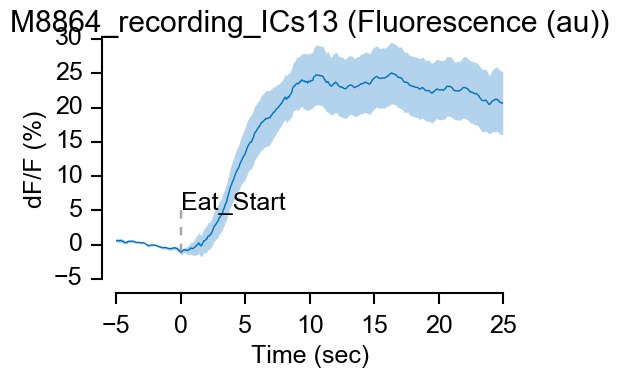

In [142]:
for cell in cellList:
    df = cellMeans[cellMeans['Cell'] == cell]
    fig, ax = plotMean(df['Mean'], df['Sem'], time)
    ax.set_title(cell)

(<matplotlib.figure.Figure at 0x12ad6e48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ad0eb8>)

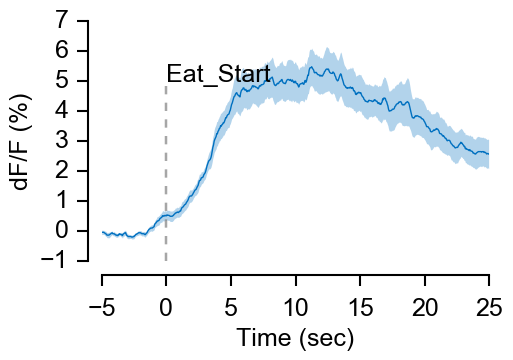

In [140]:
mean=cellMeans[cellMeans['Cell'] == cellList[5]]['Mean']
sem=cellMeans[cellMeans['Cell'] == cellList[5]]['Sem']
plotMean(mean, sem, time)

In [55]:
str(len(eventsData.pivot_table(index=['Cell'], columns='New_Time').index)) + " cells in total."

'36 cells in total.'

In [83]:
startData = markTrials(mice, base, duration, eventType='Eat_Start', trials=trials, baseline=1)
contactData = markTrials(mice, base, duration, eventType='Food_Contact', trials=trials, baseline=1)

# Calculate the mean and sem
meanstart=startData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
semstart=startData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()

meancontact=contactData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
semcontact=contactData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()

time = np.arange(-base,duration,fs)

Number of successful rewards received (hits):  15
Number of missed rewards (misses):  2
Number of successful rewards received (hits):  17
Number of missed rewards (misses):  1
Number of successful rewards received (hits):  13
Number of missed rewards (misses):  2

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

Baseline was set 1 sec before the event.
Number of successful rewards received (hits):  15
Number of missed rewards (misses):  2
Number of successful rewards received (hits):  17
Number of missed rewards (misses):  1
Number of successful rewards received (hits):  13
Number of missed rewards (misses):  2

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

Baseline was set 1 sec before the event.


In [101]:
def plotMean(mean, sem, time):
    plt.style.use('classic')
    # Set the font dictionaries (for plot title and axis titles)
    font = {'sans-serif' : 'Arial',
            'weight' : 'normal',
            'size'   : 18}
    plt.rc('font', **font)

    fig = plt.figure(figsize=(5,3), facecolor="w", dpi= 150)
    ax = plt.subplot(111)

    line = 1.5
    colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

    ## labels
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("dF/F (%)")
    #ax.set_title("Aligned to event::Update the title", fontsize= 12)

    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_top()
    ax.get_yaxis().tick_left()

    ## adjust the spines and ticks
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_linewidth(line)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_linewidth(line)
    ax.spines['bottom'].set_position(('outward', 10))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ## decorate the axes
    ax.tick_params(axis='y', color= '#000000', width= line, direction='out', length= 8, which='major', pad=10)
    ax.tick_params(axis='x', color= '#000000', width= line, direction='out', length= 8, which='major', pad=12)

    ax.fill_between(time, mean+sem, mean-sem, facecolor=colors[1], linewidth=0, alpha=0.3, zorder=-5)
    cat, = ax.plot(time, mean, colors[1], label=eventType)
    #ax.fill_between(time, meanstart+semstart, meanstart-semstart, facecolor=colors[1], linewidth=0, alpha=0.3, zorder=-5)
    #cat1, = ax.plot(time, meanstart, colors[1], label='Start')
    #ax.fill_between(time, meancontact+semcontact, meancontact-semcontact, facecolor=colors[0], linewidth=0, alpha=0.3, zorder=-5)
    #cat2, = ax.plot(time, meancontact, colors[0], label='Contact')

    ax.plot([0, 0],[-1, 5], 'gray', linestyle='--', linewidth=line*1.2, alpha=0.7)
    ax.text(0, 5, eventType)
    #ax.set_ylim([-1., 2.])

    if False:
        ## add the legend
        ax.legend([cat1, cat2], ['Start', 'Contact'])
        handles, labels = ax.get_legend_handles_labels()
        legend = plt.legend(loc= 'upper left', fontsize= 18, handles=handles, handlelength= 1.2, handleheight= 0.8, handletextpad= 0.5, frameon= False)

    #plt.tight_layout()
    return fig, ax

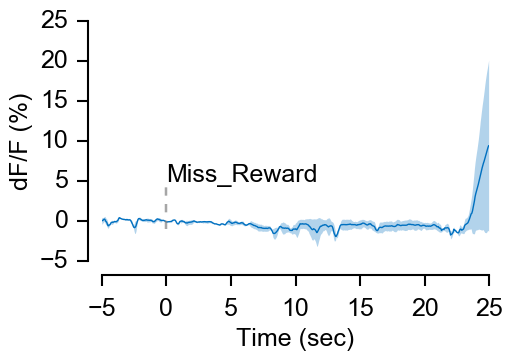

In [88]:
fig, ax = plotMean(mean, sem)

In [23]:
boutsData = markBouts(mice, ['Eat_Start', 'Eat_End'], trials=[1,12], resample=1000)

Number of successful rewards received (hits):  15
Number of missed rewards (misses):  2
Number of successful rewards received (hits):  17
Number of missed rewards (misses):  1
Number of successful rewards received (hits):  13
Number of missed rewards (misses):  2
[ 0.27027027  0.23529412  0.22222222  0.30864198  0.29498525  0.28901734
  0.3003003   0.40650407  0.33112583  0.27173913  0.30959752  0.30769231
  0.3003003   0.3125      0.11273957]
[ 0.5         0.22988506  0.21691974  0.23980815  0.24752475  0.24630542
  0.26246719  0.25062657  0.26455026  0.25906736  0.24875622  0.26455026
  0.21413276  0.24154589]
[ 0.27932961  0.29761905  0.27100271  0.30769231  0.330033    0.5
  0.33333333  0.28490028  0.27855153  0.26595745  0.28409091  0.34364261]


500 32943


ValueError: Argument dimensions are incompatible

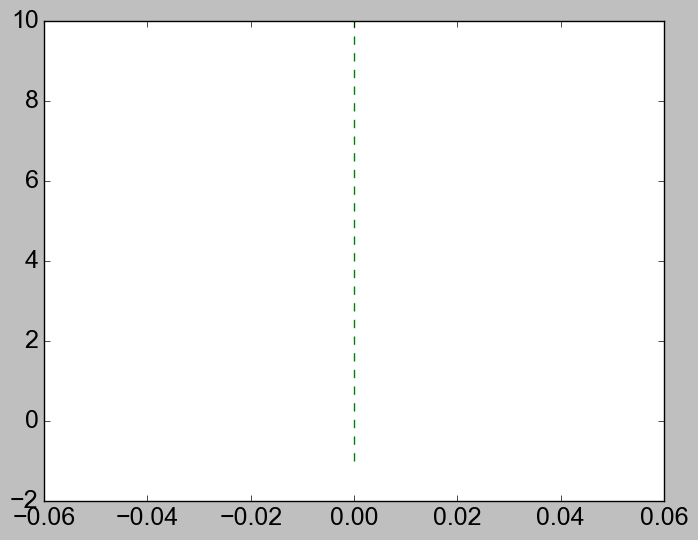

In [214]:
mean=boutsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=boutsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()

time = np.arange(-base,duration,fs)
print len(time), len(mean)
plt.plot([0, 0],[-1, 10], 'g--')
plt.fill_between(time, mean+sem, mean-sem, facecolor='gray', linewidth=0, alpha=0.3, zorder=-5)
plt.plot(time, mean)

In [117]:
heatData = eventsData.pivot_table(index=['Event'], columns='New_Time', aggfunc=np.mean)
heatData['Fluoro'].columns
heatData.mean(axis=1)

Event
1   -0.715105
2   -1.276598
dtype: float64

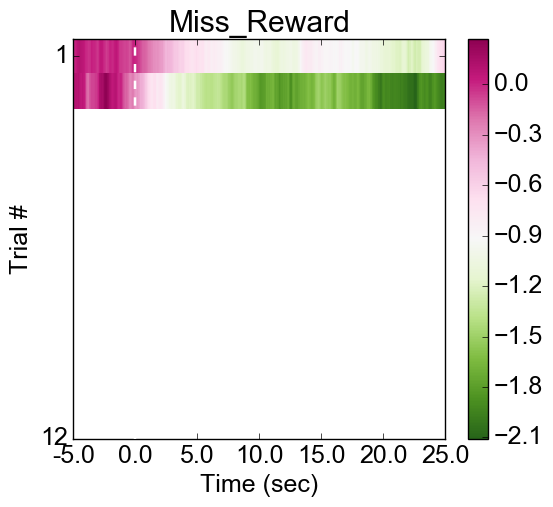

In [118]:
plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

plt.figure(figsize=(6,5), facecolor="w", dpi= 150)
ax = plt.subplot(111)

line = 1.5
colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid')
ax.invert_yaxis()
plt.colorbar()

## labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Trial #')
ax.set_title(eventType)


## decorate the axes
#ax.tick_params(axis='y', color= '#000000', width= line, direction='in', length= 4, which='major', pad=10)
#ax.tick_params(axis='x', color= '#000000', width= line, direction='in', length= 4, which='major', pad=12)
time_ax = np.arange(-base, duration+0.001, 5.0)
ax.set_xticks(np.linspace(0, (base+duration)/fs, len(time_ax)))
ax.set_xticklabels(time_ax)
ax.set_yticks(np.linspace(trials[0]-0.5, trials[1]-0.5, 2))
ax.set_yticklabels(np.linspace(trials[0], trials[1], 2, dtype=int))

ax.plot([base/fs, base/fs], list(ax.get_ylim()), 'w', linestyle='--', linewidth=line*1.2, alpha=1., zorder=111)